# Recommender system

"Small" subsets for experimentation https://nijianmo.github.io/amazon/index.html

https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/All_Beauty_5.json.gz

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict

import warnings
warnings.simplefilter('ignore')

**reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B

**asin** - ID of the product, e.g. 0000013714

**reviewerName** - name of the reviewer

**vote** - helpful votes of the review

**style** - a disctionary of the product metadata, e.g., "Format" is "Hardcover"

**reviewText** - text of the review

**overall** - rating of the product

**summary** - summary of the review

**unixReviewTime** - time of the review (unix time)

**reviewTime** - time of the review (raw)

**image** - images that users post after they have received the product

In [38]:
data = pd.read_json('All_Beauty_5.json', orient='records', lines=True)
data.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN


# EDA & Preprocessing

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [40]:
data.describe()

,overall,unixReviewTime
count,5269.000000,5.269000e+03
mean,4.771873,1.441506e+09
std,0.743204,5.473127e+07
min,1.000000,1.095725e+09
25%,5.000000,1.407024e+09
50%,5.000000,1.445645e+09
75%,5.000000,1.481674e+09
max,5.000000,1.534982e+09


Отберём количественные признаки

In [41]:
num_columns = data.select_dtypes(include='int64').columns.tolist()
num_columns

['overall', 'unixReviewTime']

Посчитаем количество уникальных признаков

In [42]:
for column in num_columns:
  print(f'{column} {data[column].nunique()}')

overall 5
unixReviewTime 883


<Axes: xlabel='overall', ylabel='count'>

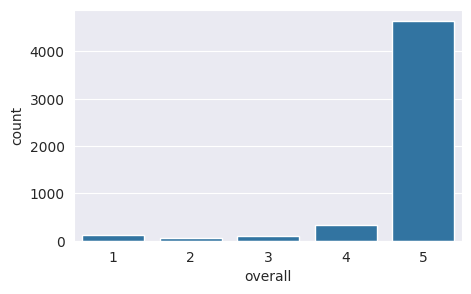

In [43]:
plt.figure(figsize=(5, 3))
sns.countplot(x='overall', data=data)

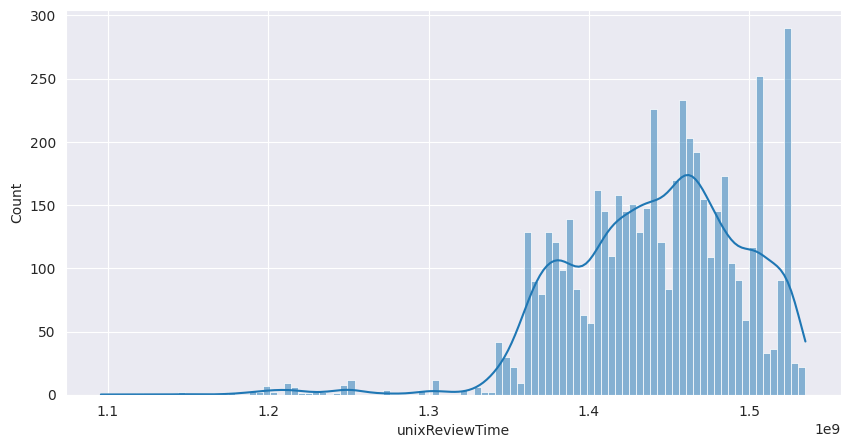

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(x='unixReviewTime', bins=100, kde=True, data=data)
plt.show()

In [45]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
cat_columns

['reviewTime',
 'reviewerID',
 'asin',
 'style',
 'reviewerName',
 'reviewText',
 'summary',
 'vote',
 'image']

In [46]:
for column in cat_columns:
  print(f'{column} {data[column].value_counts().sum()}')

reviewTime 5269
reviewerID 5269
asin 5269
style 4624
reviewerName 5269
reviewText 5264
summary 5264
vote 552
image 98


Отложим часть выборки для тестирования модели по принципу: для каждого пользователя отрежем последние 20% оценок.

In [47]:
def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):
  
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)

    # список всех пользователей
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []

    for userId in tqdm.tqdm(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])

    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)

    return X_train, X_test, y_train, y_test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data)

100%|██████████| 991/991 [00:04<00:00, 199.84it/s]


In [49]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((4048, 2), 4048, (1221, 2), 1221)

In [50]:
X_train.head(3)

,reviewerID,asin
0,A281NPSIMI1C2R,B0002JHI1I
1,A281NPSIMI1C2R,B0002JHI1I
2,A281NPSIMI1C2R,B0006O10P4


In [51]:
y_train[1:10]

array([5, 5, 5, 5, 5, 4, 5, 5, 5])

# Collaborative filtering

# User-based model


User-based model является моделью коллаборативной фильтрации, основная идея которой похожим пользователям обычно нравятся похожие объекты.
Идею алгоритма можно сформулировать следующим образом:

Найти, насколько другие пользователи в базе данных похожи на данного пользователя.

По оценкам других пользователей предсказать, какую оценку даст данный пользователь данному продукту, учитывая с большим весом тех пользователей, которые больше похожи на данного.

Определять схожесть двух пользователей будем с помощью корреляции Пирсона между векторами уже поставленными оценками. Отметим, что для двух различных пользователей оценка может иметь различный вес, так для одного средний фильм имеет рейтинг 2 , а для другого  4 . Такие пользователи похожи, но корреляция скажет, что они различны. Чтобы устранить это, давайте из всех оценок пользователя вычтем его среднюю оценку.

In [52]:
class UserBased(BaseEstimator):

    def fit(self, X, y, user_col='reviewerID', item_col='asin'):

        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из купленных предметов
        # для неизвестных предметов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между пользователями
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self

    
    def predict_rating(self, pr_user, pr_item):

        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # и модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator

    
    def predict(self, X, user_col='reviewerID', item_col='asin'):

        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [53]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [54]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ub.predict(X_test))))

start fitting...
start predicting...
rmse = 0.5010912017603278
CPU times: user 1.09 s, sys: 187 ms, total: 1.28 s
Wall time: 1.06 s


# Item-based model

Item-based model очень похожа на предыдущую модель по структуре, но теперь мы ищем похожие товары, а не пользователей. А именно, насколько другие продукты в базе данных похожи на данный продукт.
По оценкам других продуктов предсказать, какую оценку даст данный пользователь данному продукту, учитывая с большим весом те продукты, которые больше похожи на данный.

In [55]:
class ItemBased(BaseEstimator):

    def fit(self, X, y, user_col='reviewerID', item_col='asin'):

        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого предмета с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между предметами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]

        return self
    

    def predict_rating(self, pr_user, pr_item):

        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    

    def predict(self, X, user_col='reviewerID', item_col='asin'):

        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [56]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ib.predict(X_test))))

start fitting...
start predicting...
rmse = 0.5041320305507448
CPU times: user 1.06 s, sys: 190 ms, total: 1.25 s
Wall time: 1.11 s


Как мы видим, метрики в ItemBased model и UserBased model практически одинаковы